# Class Orderings for Incremental Learning

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

# Check the utils file for functions:
#     swap: Swap row and column i and j in-place.
#     move_1d: Move a block in a list.
#     move: Move rows from_start - from_end to insert_pos in-place.
#     generate_permutation: Generate a new permutation.
# and other.
import sim_anneal_utils as sau

## Loading the model (from [FACIL](https://github.com/mmasana/FACIL))

In [2]:
# See `script_facil.sh` for generating the different model seeds.
MODEL_FILE = f'results/cifar100_seed0.ckpt'
FACIL_PATH = '/home/mmasana/PycharmProjects/FACIL/'
sys.path.append(FACIL_PATH + 'src/')

In [3]:
from networks.resnet32 import resnet32
from networks.network import LLL_Net

init_model = resnet32()
model = LLL_Net(init_model, remove_existing_head=True)
model.add_head(100)
model.set_state_dict(torch.load(MODEL_FILE))

## Getting the data

In [4]:
# Dataloader from FACIL
from datasets.data_loader import get_loaders
trn_loader, _, _, _ = get_loaders(['cifar100_fixed'], 1, None, 128, num_workers=4, pin_memory=False)

# Data from torchvision
from torchvision.datasets.cifar import CIFAR100
cifar100_data = CIFAR100('/data/datasets/cifar100/', train=True, download=True)

class_names = np.array(cifar100_data.classes)[trn_loader[0].dataset.class_indices]
print(class_names)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
['apple' 'aquarium_fish' 'baby' 'bear' 'beaver' 'bed' 'bee' 'beetle'
 'bicycle' 'bottle' 'bowl' 'boy' 'bridge' 'bus' 'butterfly' 'camel' 'can'
 'castle' 'caterpillar' 'cattle' 'chair' 'chimpanzee' 'clock' 'cloud'
 'cockroach' 'couch' 'crab' 'crocodile' 'cup' 'dinosaur' 'dolphin'
 'elephant' 'flatfish' 'forest' 'fox' 'girl' 'hamster' 'house' 'kangaroo'
 'keyboard' 'lamp' 'lawn_mower' 'leopard' 'lion' 'lizard' 'lobster' 'man'
 'maple_tree' 'motorcycle' 'mountain' 'mouse' 'mushroom' 'oak_tree'
 'orange' 'orchid' 'otter' 'palm_tree' 'pear' 'pickup_truck' 'pine_tree'
 'plain' 'plate' 'poppy' 'porcupine' 'possum' 'rabbit' 'raccoon' 'ray'
 'road' 'rocket' 'rose' 'sea' 'seal' 'shark' 'shrew' 'skunk' 'skyscraper'
 'snail' 'snake' 'spider' 'squirrel' 'streetcar' 'sunflower'
 'sweet_pepper' 'table' 'tank' 'telephone' 'television' 'tiger' 'tractor'
 'train' 'trout' 'tulip' 'turtle' 'wa

In [5]:
c100_coarse_lbl = np.array(['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
                            'household electrical devices', 'household furniture', 'insects', 'large carnivores',
                            'large man-made outdoor things', 'large natural outdoor scenes',
                            'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates',
                            'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'])

c100_fine_lbl = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium_fish', 'flatfish', 'ray', 'shark',
                 'trout', 'orchid', 'poppy', 'rose', 'sunflower', 'tulip', 'bottle', 'bowl', 'can', 'cup', 'plate',
                 'apple', 'mushroom', 'orange', 'pear', 'sweet_pepper', 'clock', 'keyboard', 'lamp', 'telephone',
                 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 'bee', 'beetle', 'butterfly',
                 'caterpillar', 'cockroach', 'bear', 'leopard', 'lion', 'tiger', 'wolf', 'bridge', 'castle',
                 'house', 'road', 'skyscraper', 'cloud', 'forest', 'mountain', 'plain', 'sea', 'camel', 'cattle',
                 'chimpanzee', 'elephant', 'kangaroo', 'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'crab',
                 'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man', 'woman', 'crocodile',
                 'dinosaur', 'lizard', 'snake', 'turtle', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
                 'maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree', 'bicycle', 'bus', 'motorcycle',
                 'pickup_truck', 'train', 'lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']

class_group_idx = np.array([c100_fine_lbl.index(n) // 5 for n in class_names])
class_group = c100_coarse_lbl[class_group_idx]

# uncomment to see pairs of labels
# list(zip(class_names, class_group))

## Evaluating the data

In [6]:
n_all = 0
n_hit = 0
n_cls = len(np.unique(trn_loader[0].dataset.labels))
conf_mat = torch.zeros(n_cls, n_cls)

with torch.no_grad():
    model.cuda()
    model.eval()
    for images, targets in trn_loader[0]:
        outputs = model(images.cuda())
        preds = outputs[0].argmax(1)
        n_all += len(targets)
        n_hit += (preds == targets.cuda()).sum().item()
        for t, p in zip(targets.view(-1), preds.view(-1)):
            conf_mat[t.long(), p.long()] += 1

print('Model accuracy: {}'.format((100.0 * n_hit) / n_all))

Model accuracy: 62.03777777777778


## Visualizing results

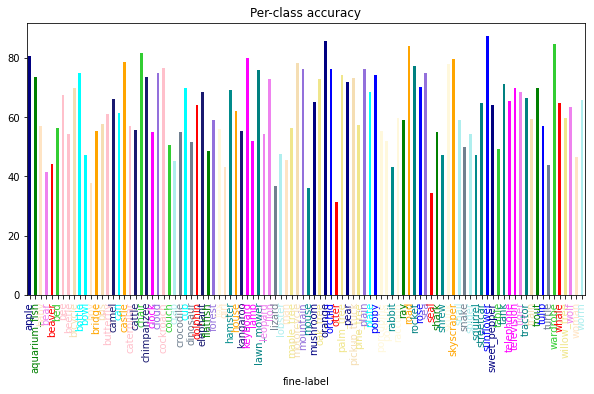

In [7]:
df = pd.DataFrame({"fine-label" : class_names,
                   "accuracy" : 100.0 * (conf_mat.diag() / conf_mat.sum(1)).cpu().numpy(),
                   "coarse-label" : class_group})
# Uncomment to see per-class accuracy values
# print(df)

group_color = ['red', 'green', 'blue', 'cyan', 'navy', 'magenta', 'limegreen', 'pink', 'violet', 'orange', 
               'mediumpurple', 'midnightblue', 'cornsilk', 'paleturquoise', 'bisque', 'slategray', 'darkcyan',
               'khaki', 'wheat', 'teal']
class_colors = [group_color[i] for i in class_group_idx]

ax = df.set_index(['fine-label']).accuracy.plot.bar(figsize=(10,5), title='Per-class accuracy', color=class_colors)    

for xtick, color in zip(ax.get_xticklabels(), class_colors): 
        xtick.set_color(color);

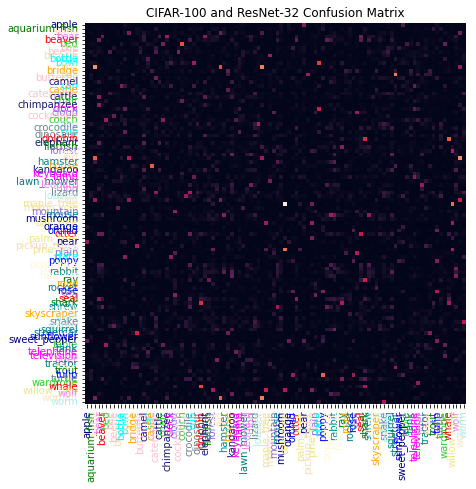

In [8]:
def plot_cm(cm, order = np.arange(100), log=False, title='CIFAR-100 and ResNet-32 Confusion Matrix'):
    m = cm
    if log:
        m = np.log(m + 1)
    m[np.arange(m.shape[0]), np.arange(m.shape[1])] = 0
    m = sau.apply_permutation(m, order)
    x = class_names[order]
    plt.figure(figsize=(7,7))
    ax = sns.heatmap(m, xticklabels=x, yticklabels=x, square = True, cbar=False, )
    plt.title(title)
    for xtick, ytick, c_idx in zip(ax.get_xticklabels(), ax.get_yticklabels(), order): 
        xtick.set_color(class_colors[c_idx]); ytick.set_color(class_colors[c_idx]);

cm = conf_mat.cpu().numpy()
plot_cm(cm)

### Order by coarse grained labels

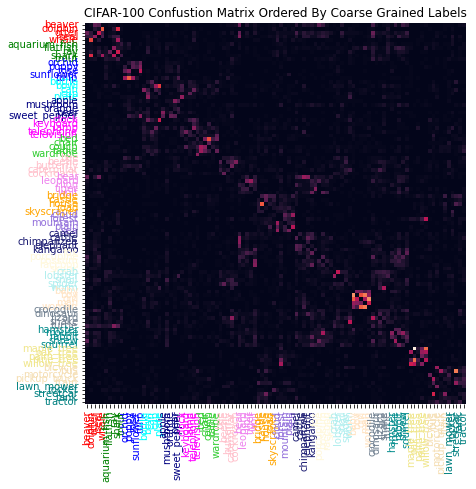

In [9]:
groups_perm = [i for _, i in sorted([(class_group_idx[i], i) for i in np.arange(100)])]
plot_cm(cm, order=groups_perm, title='CIFAR-100 Confustion Matrix Ordered By Coarse Grained Labels')

## Confusion Matrix Ordering

### Greedy approach

In [10]:
def cmo_greedy(m, classes_per_task=[10] * 10, max_confusion=True):
    m = m.copy()
    if max_confusion:
        m[np.arange(m.shape[0]), np.arange(m.shape[1])] = 0
    else: 
        m[np.arange(m.shape[0]), np.arange(m.shape[1])] = -m[np.arange(m.shape[0]), np.arange(m.shape[1])]
    print('Classes per tasks: ', classes_per_task)
    assert m.shape[0] == m.shape[1]
    assert sum(classes_per_task) == m.shape[0]
    
    solution = []
    i_start = 0
    for n_classes in classes_per_task:
        i_end = i_start + n_classes
        # predicion (col) vs true
        fp = m[:, i_start: i_end].sum(1).flatten()
        # true (row) vs pred
        fn = m[i_start: i_end, :].sum(0).flatten()
        fp = m.sum(1).flatten()
        # true (row) vs pred
        fn = m.sum(0).flatten()

        score = fp + fn
        order = score.argsort()
        if max_confusion:
            order = order[::-1] # desc
        n = 0
        for i in order:
            if i not in solution:
                solution.append(i)
                n += 1
                if n == n_classes:
                    break

        i_start = i_end
    return solution

In [11]:
splits = [20] * 5
split_max_confusion = np.array(cmo_greedy(cm, classes_per_task=splits))
print('Max confusion split')
print(split_max_confusion)
print('---')
split_min_confusion = np.array(cmo_greedy(cm, classes_per_task=splits, max_confusion=False))
print('Min confusion split')
print(split_min_confusion)

Classes per tasks:  [20, 20, 20, 20, 20]
Max confusion split
[72  3 65 55 44 50 80 27 46 10 98  4 38  2 64 78 73 35 18 15 33 74 45 32
 25 11 96 97 67 93 40 63 26 99 59 30 92 51 31 37 34 13 29 86 22 79 19 28
 12 21 84 81 90 95 52 77 47 89 61  5 16  7 66 42 83 36 87 23 14 85 62 43
 88 60 57  1 71  6  9 49  8 17 69 48 91 41 70 54 39 76 20 75 24 94 56 68
 58  0 82 53]
---
Classes per tasks:  [20, 20, 20, 20, 20]
Min confusion split
[53 82  0 58 68 56 94 24 75 20 76 39 54 70 41 91 48 69 17  8 49  9  6 71
  1 57 60 88 43 62 85 14 23 87 36 83 42 66  7 16  5 61 89 47 77 52 95 90
 81 84 21 12 28 19 79 22 86 29 13 34 37 31 51 92 30 59 99 26 63 40 93 67
 97 96 11 25 32 45 74 33 15 18 35 73 78 64  2 38  4 98 10 46 27 80 50 44
 55 65  3 72]


## Find solution with simulated annealing

A similar problem is described [[here](https://cs.stackexchange.com/questions/70627/how-can-i-restructure-matrices-to-have-non-zero-elements-close-to-the-diagonal)] as **Confusion Matrix Ordering**.

The author proposed a solution based on SA optimization, and was used in his [mater thesis](https://arxiv.org/pdf/1707.09725.pdf).

This weight matrix will be used for weighting the confusion matrix values.

In this case, we would like to get confusion "along" the diagonal of the confusion matrix.

In [12]:
STEPS = 20 * 10 ** 5


def simulated_annealing(
    current_cm,
    current_perm=None,
    score=sau.calculate_score,
    steps=2 * 10 ** 5,
    temp=100.0,
    cooling_factor=0.99,
    deterministic=False,
    calculate_weight_matrix=sau.calculate_weight_matrix
):
    """
    Optimize current_cm by randomly swapping elements.
    Parameters
    ----------
    current_cm : ndarray
    current_perm : None or iterable, optional (default: None)
    steps : int, optional (default: 2 * 10**4)
    temp : float > 0.0, optional (default: 100.0)
        Temperature
    cooling_factor: float in (0, 1), optional (default: 0.99)
    Returns
    -------
    best_result : Dict[str, Any]
        "best_cm"
        "best_perm"
    """
    if temp <= 0.0:
        raise ValueError("temp={} needs to be positive".format(temp))
    if cooling_factor <= 0.0 or cooling_factor >= 1.0:
        raise ValueError(
            "cooling_factor={} needs to be in the interval "
            "(0, 1)".format(cooling_factor)
        )
    n = len(current_cm)
    if current_perm is None:
        current_perm = list(range(n))
    current_perm = np.array(current_perm)

    # Pre-calculate weights
    weights = calculate_weight_matrix(n)

    # Apply the permutation
    current_cm = sau.apply_permutation(current_cm, current_perm)
    current_score = score(current_cm, weights)

    best_cm = current_cm
    best_score = current_score
    best_perm = current_perm

    _scores=[]
    _scores_step = 1000
    
    # print("## Starting Score: {:0.2f}".format(current_score))
    pbar = tqdm(range(steps))
    for step in pbar:
        tmp_cm = np.array(current_cm, copy=True)
        perm, make_swap = sau.generate_permutation(n, current_perm, tmp_cm)
        tmp_score = score(tmp_cm, weights)

        if deterministic:
            chance = 1.0
        else:
            chance = random.random()
            temp *= 0.99
        hot_prob_thresh = min(1, np.exp(-(tmp_score - current_score) / temp))
        if chance <= hot_prob_thresh:
            changed = False
            if best_score > tmp_score:  # minimize
                best_perm = perm
                best_cm = tmp_cm
                best_score = tmp_score
                changed = True
            current_score = tmp_score
            current_cm = tmp_cm
            current_perm = perm
            
            if changed:
                pbar.set_description("Current: %0.2f (best: %0.2f)" % (current_score, best_score))
        if step > _scores_step * 2 and step % _scores_step == 0:
            _scores.append(best_score)

    plt.figure()
    plt.plot(np.arange(len(_scores)) * _scores_step, _scores)
    plt.title('Optimization scrore')
    
    return {"cm": best_cm, "perm": best_perm, "scores": _scores}


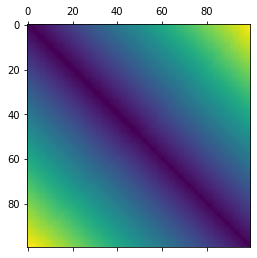

In [13]:
def calculate_weight_matrix(n):
    weights = np.abs(np.arange(n) - np.arange(n)[:, None])
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            weights[i][j] += (i + j) * 0.01
    return weights

plt.matshow(calculate_weight_matrix(100))

### Maximum confusion

  0%|          | 0/2000000 [00:00<?, ?it/s]

/tmp/ipykernel_2470055/3545866580.py:68: RuntimeWarning: overflow encountered in exp
  hot_prob_thresh = min(1, np.exp(-(tmp_score - current_score) / temp))


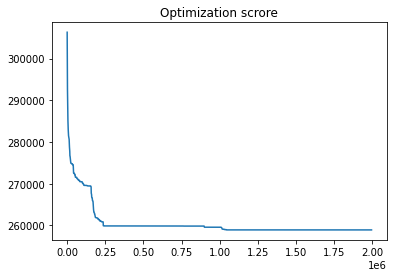

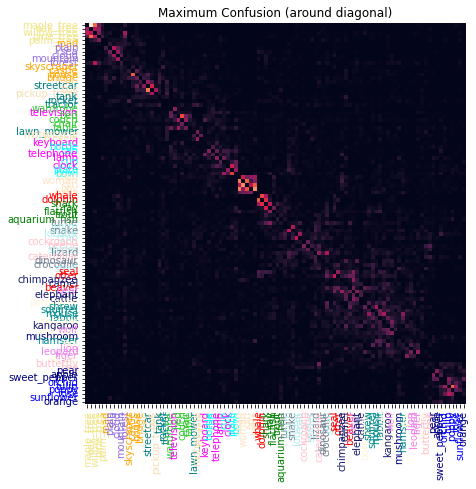

In [14]:
r = simulated_annealing(cm.copy(), steps=STEPS,
                        score=sau.calculate_score,
                        calculate_weight_matrix=calculate_weight_matrix)
split_max_confusion_sa = r['perm']
cm_max_confusion_sa = r['cm']
plot_cm(cm, order=split_max_confusion_sa, title = 'Maximum Confusion (around diagonal)')

### Minimum confusion

  0%|          | 0/2000000 [00:00<?, ?it/s]

/tmp/ipykernel_2470055/3545866580.py:68: RuntimeWarning: overflow encountered in exp
  hot_prob_thresh = min(1, np.exp(-(tmp_score - current_score) / temp))


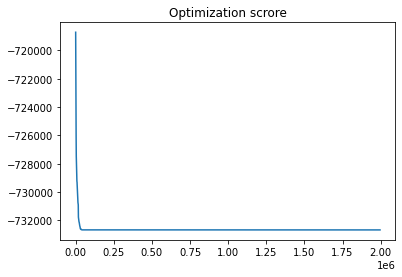

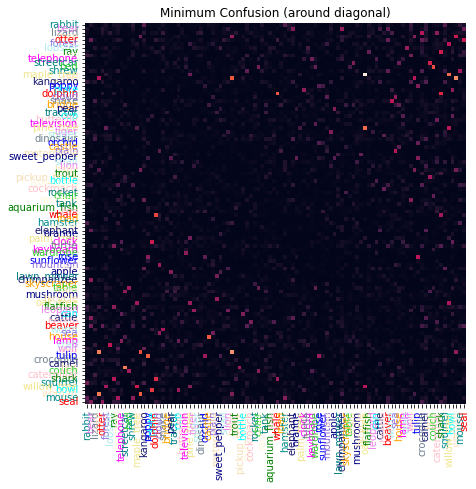

In [15]:
r = simulated_annealing(cm.copy(), steps=STEPS,
                        score=sau.calculate_score_min,
                        calculate_weight_matrix=calculate_weight_matrix)
split_min_confusion_sa = r['perm']
cm_min_confusion_sa = r['cm']
plot_cm(cm, order=split_min_confusion_sa, title = 'Minimum Confusion (around diagonal)')

### Decreasing Confusion with Tasks Bounduaries

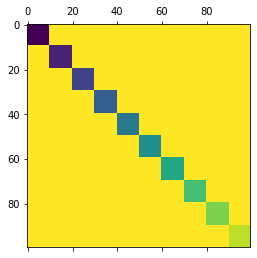

In [16]:
def calculate_weight_matrix_dec_tasks(n, n_tasks=10):
    weights = np.ones((n, n)) * 99.9
    tc = int(n / n_tasks)
    for i_start in range(0, n, tc):
        i_end = i_start + tc
        weights[i_start:i_end, i_start:i_end] = i_start 
    return weights

plt.matshow(calculate_weight_matrix_dec_tasks(100))

  0%|          | 0/2000000 [00:00<?, ?it/s]

/tmp/ipykernel_2470055/3545866580.py:68: RuntimeWarning: overflow encountered in exp
  hot_prob_thresh = min(1, np.exp(-(tmp_score - current_score) / temp))


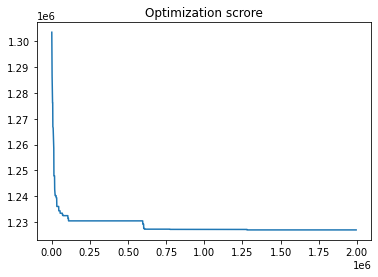

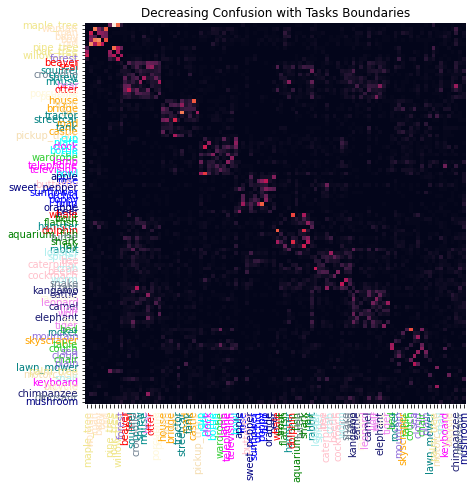

In [17]:
r = simulated_annealing(cm.copy(), steps=STEPS,
                        score=sau.calculate_score,
                        calculate_weight_matrix=calculate_weight_matrix_dec_tasks)
split_dec_confusion_sa_tasks = r['perm']
cm_dec_confusion_sa_tasks = r['cm']
plot_cm(cm, order=split_dec_confusion_sa_tasks, title = 'Decreasing Confusion with Tasks Boundaries')

### Increasing Confusion Tasks Bounduaries

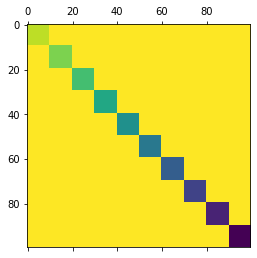

In [18]:
def calculate_weight_matrix_inc_tasks(n, n_tasks=10):
    weights = np.ones((n, n)) * 99.9
    tc = int(n / n_tasks)
    for i_start in range(0, n, tc):
        i_end = i_start + tc
        weights[i_start:i_end, i_start:i_end] = 100 - i_end
    return weights

plt.matshow(calculate_weight_matrix_inc_tasks(100))

  0%|          | 0/2000000 [00:00<?, ?it/s]

/tmp/ipykernel_2470055/3545866580.py:68: RuntimeWarning: overflow encountered in exp
  hot_prob_thresh = min(1, np.exp(-(tmp_score - current_score) / temp))


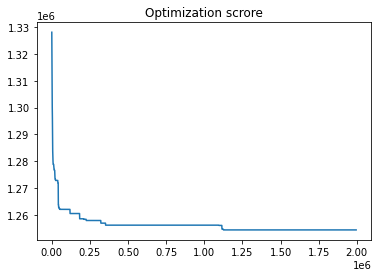

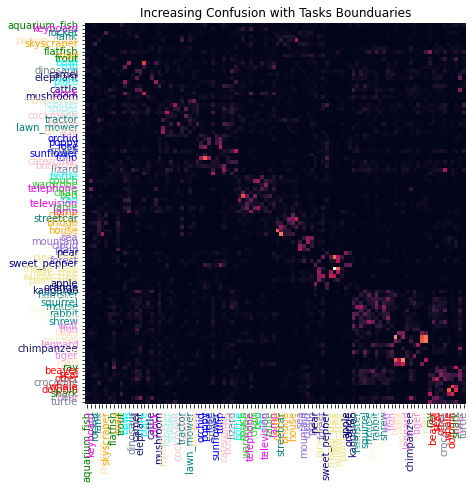

In [19]:
r = simulated_annealing(cm.copy(), steps=STEPS,
                        score=sau.calculate_score,
                        calculate_weight_matrix=calculate_weight_matrix_inc_tasks)
split_inc_confusion_sa_tasks = r['perm']
cm_inc_sa_tasks = r['cm']
plot_cm(cm, order=split_inc_confusion_sa_tasks, title = 'Increasing Confusion with Tasks Bounduaries')

### Equal Confusion Tasks Bounduaries

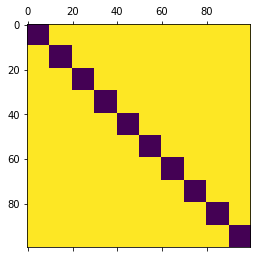

In [20]:
def calculate_weight_matrix_eq_tasks(n, n_tasks=10):
    weights = np.ones((n, n)) * 99.9
    tc = int(n / n_tasks)
    for i_start in range(0, n, tc):
        i_end = i_start + tc
        weights[i_start:i_end, i_start:i_end] = 0
    return weights

plt.matshow(calculate_weight_matrix_eq_tasks(100))

  0%|          | 0/2000000 [00:00<?, ?it/s]

/tmp/ipykernel_2470055/3545866580.py:68: RuntimeWarning: overflow encountered in exp
  hot_prob_thresh = min(1, np.exp(-(tmp_score - current_score) / temp))


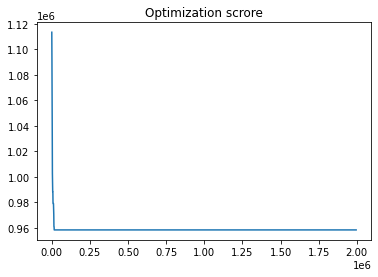

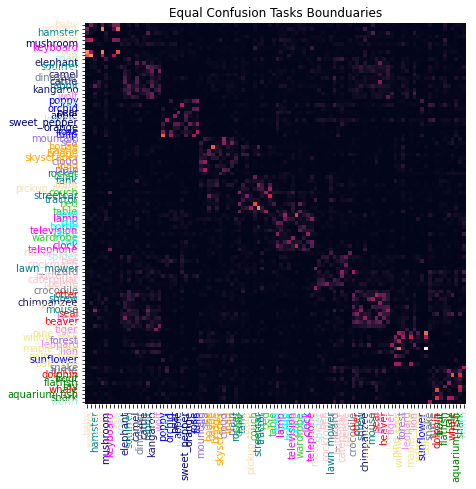

In [21]:
r = simulated_annealing(cm.copy(), steps=STEPS,
                        score=sau.calculate_score,
                        calculate_weight_matrix=calculate_weight_matrix_eq_tasks)
split_eq_confusion_sa_tasks = r['perm']
cm_eq_confusion_sa_tasks = r['cm']
plot_cm(cm, order=split_eq_confusion_sa_tasks, title = 'Equal Confusion Tasks Bounduaries')

### Extra: Minimum Confusion (along diagonal) with Tasks Bounduaries

  0%|          | 0/2000000 [00:00<?, ?it/s]

/tmp/ipykernel_2470055/3545866580.py:68: RuntimeWarning: overflow encountered in exp
  hot_prob_thresh = min(1, np.exp(-(tmp_score - current_score) / temp))


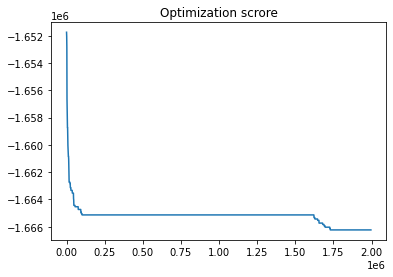

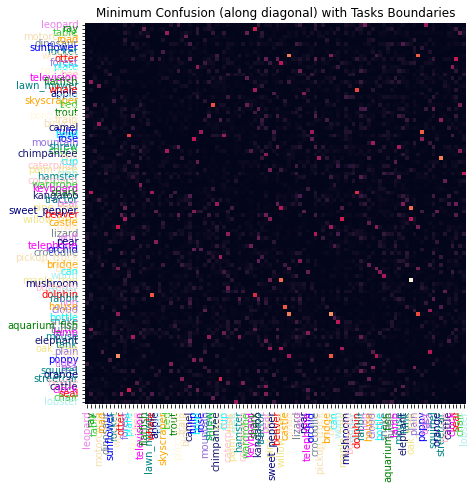

In [22]:
r = simulated_annealing(cm.copy(), steps=STEPS,
                        score=sau.calculate_score_min,
                        calculate_weight_matrix=calculate_weight_matrix_eq_tasks)
split_min_confusion_sa_tasks = r['perm']
cm_min_confusion_sa_tasks = r['cm']
plot_cm(cm, order=split_min_confusion_sa_tasks, title = 'Minimum Confusion (along diagonal) with Tasks Boundaries')

## Class orders

In [23]:
# Maximum Confusion with simulated annealing
print([trn_loader[0].dataset.class_indices[i] for i in split_max_confusion_sa])

[47, 52, 96, 59, 56, 68, 60, 71, 23, 49, 33, 76, 17, 37, 12, 90, 81, 13, 58, 85, 69, 89, 94, 87, 5, 25, 20, 84, 41, 48, 8, 39, 9, 16, 86, 40, 28, 22, 61, 10, 46, 98, 35, 11, 2, 95, 30, 73, 67, 32, 91, 1, 93, 99, 78, 45, 26, 24, 7, 79, 44, 18, 29, 27, 77, 72, 55, 21, 15, 4, 3, 31, 19, 63, 74, 80, 50, 65, 64, 38, 97, 66, 51, 36, 34, 43, 42, 88, 75, 14, 6, 57, 0, 83, 54, 92, 62, 70, 82, 53]


In [24]:
# Minimum Confusion with simulated annealing
print([trn_loader[0].dataset.class_indices[i] for i in split_min_confusion_sa])

[65, 3, 44, 46, 55, 33, 45, 67, 64, 86, 81, 5, 74, 47, 35, 38, 62, 61, 30, 23, 78, 12, 57, 89, 28, 14, 87, 59, 88, 79, 29, 54, 17, 60, 48, 83, 77, 43, 2, 91, 58, 9, 63, 24, 69, 20, 66, 85, 1, 6, 95, 68, 36, 75, 31, 53, 56, 22, 93, 39, 94, 70, 82, 49, 34, 0, 41, 21, 76, 84, 90, 51, 8, 52, 32, 42, 16, 19, 7, 4, 99, 71, 37, 40, 26, 97, 11, 92, 27, 15, 13, 25, 18, 73, 80, 96, 10, 98, 50, 72]


In [25]:
# Increasing Confusion (task boundaries) with simulated annealing
print([trn_loader[0].dataset.class_indices[i] for i in split_inc_confusion_sa_tasks])

[1, 39, 69, 85, 58, 76, 75, 32, 68, 91, 10, 28, 29, 15, 31, 61, 77, 19, 22, 51, 48, 45, 79, 26, 24, 89, 7, 41, 8, 6, 54, 62, 70, 78, 82, 92, 18, 14, 44, 99, 9, 25, 94, 86, 20, 5, 16, 87, 84, 40, 17, 81, 12, 90, 37, 13, 71, 49, 23, 60, 57, 59, 33, 83, 47, 52, 96, 56, 0, 53, 38, 36, 64, 80, 50, 63, 65, 66, 74, 97, 43, 2, 11, 98, 42, 21, 34, 88, 35, 46, 67, 4, 72, 55, 27, 95, 30, 73, 3, 93]


In [26]:
# Decreasing Confusion (task boundaries) with simulated annealing
print([trn_loader[0].dataset.class_indices[i] for i in split_dec_confusion_sa_tasks])

[47, 98, 46, 2, 11, 35, 59, 52, 96, 33, 4, 72, 80, 27, 74, 50, 3, 55, 63, 64, 37, 90, 12, 13, 89, 81, 68, 85, 17, 58, 28, 61, 22, 9, 16, 94, 40, 86, 87, 10, 0, 70, 14, 83, 82, 54, 62, 92, 53, 57, 95, 91, 32, 36, 30, 1, 93, 73, 67, 65, 45, 79, 6, 18, 26, 7, 24, 99, 78, 44, 38, 19, 66, 42, 15, 43, 97, 31, 34, 88, 5, 69, 49, 76, 84, 25, 71, 23, 20, 60, 41, 56, 48, 77, 39, 8, 75, 21, 29, 51]


In [27]:
# Equal Confusion (task boundaries) with simulated annealing
print([trn_loader[0].dataset.class_indices[i] for i in split_eq_confusion_sa_tasks])

[2, 98, 36, 75, 46, 51, 39, 11, 35, 77, 31, 80, 66, 15, 29, 19, 65, 38, 34, 97, 62, 26, 54, 57, 0, 45, 83, 53, 70, 92, 49, 71, 37, 17, 12, 76, 23, 68, 60, 69, 20, 85, 90, 58, 25, 81, 89, 5, 13, 84, 10, 40, 28, 9, 87, 61, 94, 16, 22, 86, 48, 79, 6, 24, 41, 44, 14, 18, 7, 8, 27, 55, 74, 21, 63, 50, 72, 3, 4, 64, 88, 59, 96, 33, 42, 47, 43, 56, 82, 52, 78, 93, 30, 91, 32, 67, 95, 1, 73, 99]


In [28]:
# Extra: Minimum Confusion (task boundaries) with simulated annealing
print([trn_loader[0].dataset.class_indices[i] for i in split_min_confusion_sa_tasks])

[42, 67, 84, 48, 68, 29, 82, 69, 98, 55, 33, 61, 64, 6, 87, 32, 41, 95, 0, 77, 76, 5, 34, 91, 63, 90, 8, 15, 92, 10, 70, 49, 74, 25, 21, 13, 28, 18, 56, 26, 36, 24, 94, 39, 73, 38, 89, 3, 59, 83, 4, 96, 17, 46, 75, 44, 97, 57, 86, 54, 27, 58, 66, 12, 2, 16, 99, 47, 51, 14, 79, 30, 65, 43, 37, 23, 11, 9, 78, 1, 93, 40, 50, 31, 85, 52, 60, 35, 62, 88, 71, 80, 53, 81, 7, 19, 22, 72, 20, 45]
